In [36]:
compounds_str = """
part1-CO2_50-FeO_50:
CO2: 50%
FeO: 50%

part2-CO_20-Fe_50-AgO_20-AlO_10:
CO: 20%
Fe: 50%
AgO: 20%
AlO: 10%

part3-HCO2_15-FeO2_60-Ag_25:
HCO2: 15%
FeO2: 60%
Ag: 25%

part4-HCO2_20-FeO2_60-Ag_20:
HCO2: 20%
FeO2: 60%
Ag: 20%
"""


In [37]:
import random
from typing import Tuple, Dict, List, DefaultDict
from dataclasses import dataclass
from collections import defaultdict
import datetime
import string

import torch, torch.optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from IPython import display

sns.set_theme()

@dataclass
class Molecule:
    name: str
    value: float

    def __repr__(self) -> str:
        return f"{self.name} @ {self.value}"

@dataclass
class Compound:
    name: str
    molecules: List[Molecule]

    def __init__(self, name: str):
        self.name = name
        self.molecules = list()
    
    def __repr__(self) -> str:
        mols_str = ", ".join(map(repr, self.molecules))
        return f"{self.name} ({mols_str})"

@dataclass
class Oil:
    name: str
    compounds: List[Compound]

@dataclass
class Reading:
    molecules: List[Molecule]

# mine
def DistanceLoss(out, truth):
    return torch.abs((truth - out)).mean()

# https://stats.stackexchange.com/questions/438728/mean-absolute-percentage-error-returning-nan-in-pytorch
def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / (target + 1e-6)))
def RPDLoss(output, target):
  return torch.mean(torch.abs(target - output) / ((torch.abs(target) + torch.abs(output)) / 2))    

@dataclass
class Config:
    compounds: List[Compound]
    all_comp_names: List[str]
    compname_idx: Dict[str, int]
    all_mol_names: List[str]
    molname_idx: Dict[str, int]

    net: nn.Module = None
    loss_fn: nn.Module = None
    optim: torch.optim.Optimizer = None
    device: str = ""

    def __init__(self, s: str):
        compounds = Config.parse_compounds(s)
        self.compounds = compounds

        self.all_comp_names = sorted([comp.name for comp in compounds])
        self.compname_idx = {name: idx for idx, name in enumerate(self.all_comp_names)}

        self.all_mol_names = [mol.name for comp in compounds for mol in comp.molecules]
        self.all_mol_names = sorted(list(set(self.all_mol_names)))
        self.molname_idx = {name: idx for idx, name in enumerate(self.all_mol_names)}

    def parse_compounds(s: str) -> List[Compound]:
        res: List[Compound] = list()
        curcomp: Compound = None
        for line in s.splitlines():
            if "#" in line:
                line = line[:line.index("#")]
            line = line.strip()

            if not line:
                continue

            if line.endswith(":"):
                collname = line[:-1]
                curcomp = Compound(collname)
                res.append(curcomp)
                continue

            if ":" not in line:
                print(f"can't parse '{line}'")
                continue

            mname, mvalue = [w.strip() for w in line.split(":")]
            if "%" in mvalue:
                mvalue = float(mvalue[:-1]) / 100.0
            else:
                mvalue = float(mvalue)
            
            part = Molecule(mname, mvalue)
            curcomp.molecules.append(part)
        
        return res

    def setup(self, num_hidden: int, hidden_size: int, lr: float):
        if torch.cuda.is_available():
            self.device = "cuda"
        else:
            self.device = "cpu"

        num_molecules = len(self.all_mol_names)
        num_compounds = len(self.all_comp_names)

        self.net = nn.Sequential()
        self.net.append(nn.Linear(num_molecules, hidden_size))
        for _ in range(num_hidden):
            self.net.append(nn.Linear(hidden_size, hidden_size))
            self.net.append(nn.ReLU())
        self.net.append(nn.Linear(hidden_size, num_compounds))
        self.net.append(nn.Softmax(dim=1))
        self.net = self.net.to(self.device)

        # self.loss_fn = nn.L1Loss().to(self.device)
        # self.loss_fn = nn.CrossEntropyLoss().to(self.device)
        # self.loss_fn = nn.MultiLabelSoftMarginLoss().to(self.device)
        # self.loss_fn = nn.BCELoss().to(self.device)

        # self.loss_fn = DistanceLoss()
        self.loss_fn = RPDLoss
        self.optim = torch.optim.AdamW(self.net.parameters(), lr=lr)

def gen_examples(cfg: Config, num_batches: int, batch_size: int):
    res: List[torch.Tensor, torch.Tensor] = list()
    for example_idx in range(num_batches):
        truth_ingreds = torch.zeros((batch_size, len(cfg.all_comp_names), ))
        measurement_mols = torch.zeros((batch_size, len(cfg.all_mol_names), ))

        for batch_idx in range(batch_size):
            num_compounds = torch.randint(0, len(cfg.compounds), (1,)).item() + 1

            compounds_shuffled = cfg.compounds.copy()
            random.shuffle(compounds_shuffled)

            # print(f"example {example_idx}:")

            total_ingred = 0.0
            total_mol = 0.0
            for ingred_idx in range(num_compounds):
                ingred = compounds_shuffled[ingred_idx]
                ingred_used = torch.rand((1,)) * 10.0
                ingred_used = (torch.abs(ingred_used) + 0.1).item()

                total_ingred += ingred_used
                truth_ingreds[batch_idx][cfg.compname_idx[ingred.name]] += ingred_used

                # print(f"  used {ingred.name} @ {ingred_used:.3f}")

                # print(f"{example_idx=}, {ingred_idx=}: {ingred=}")
                for m in ingred.molecules:
                    val = m.value * ingred_used
                    measurement_mols[batch_idx][cfg.molname_idx[m.name]] += val
                    total_mol += val

            truth_ingreds[batch_idx] /= total_ingred
            measurement_mols[batch_idx] /= total_mol

            # print()
            # for name in cfg.all_mol_names:
            #     val = measurement_mols[cfg.molname_idx[name]]
            #     print(f"   mol {name} @ {val:.3f}")
            # print()
            # print(f"  measurement_mols = {measurement_mols}")
            # print(f"  truth_ingreds = {truth_ingreds}")
        
        measurement_mols = measurement_mols.to(cfg.device)
        truth_ingreds = truth_ingreds.to(cfg.device)
        res.append((measurement_mols, truth_ingreds))
    
    return res

def train(cfg: Config, 
          num_epochs: int,
          data_train: torch.Tensor, data_val: torch.Tensor):

    train_loss_hist = list()
    val_loss_hist = list()
    val_dist_hist = list()

    last_print = datetime.datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0.0

        for measurement, truth in data_train:
            out = cfg.net(measurement)
            loss = cfg.loss_fn(out, truth)
            loss.backward()
            train_loss += loss.item()

            cfg.optim.step()
        
        train_loss /= len(data_train)

        with torch.no_grad():
            val_loss = 0.0
            val_dist = 0.0
            for batch, (measurement, truth) in enumerate(data_val):
                val_out = cfg.net(measurement)
                val_loss += cfg.loss_fn(val_out, truth).item()
                val_dist += DistanceLoss(val_out, truth).item()
            val_loss /= len(data_val)
            val_dist /= len(data_val)

        now = datetime.datetime.now()
        if (now - last_print) >= datetime.timedelta(seconds=5) or (epoch == num_epochs - 1):
            print(f"epoch {epoch+1}/{num_epochs}: train loss {train_loss:.5f}, val loss {val_loss:.5f}, val dist {val_dist:.5f}")
            last_print = now

        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        val_dist_hist.append(val_dist)
      
    return train_loss_hist, val_loss_hist, val_dist_hist

def show_result(cfg: Config, examples: List[Tuple[torch.Tensor, torch.Tensor]]):
    def show_one(logits: torch.Tensor, truth: torch.Tensor):
        inf_str, truth_str = "inference", "truth"
        part_str, part_len = "part", max([len(c) for c in cfg.all_comp_names])
        part_str = part_str.rjust(part_len, " ")

        print(f"{part_str} | {inf_str:10} | {truth_str:10}")
        for n in range(len(logits)):
            infval, truthval = logits[n].item() * 100, truth[n].item() * 100
            compname = cfg.all_comp_names[n]
            compname = compname.rjust(part_len, " ")
            print(f"{compname} | {infval:9.3f}% | {truthval:9.3f}%")

    with torch.no_grad():
        for batch in examples:
            measurements_batch, truth_batch = batch
            logits_batch = cfg.net(measurements_batch)
            for i in range(len(logits_batch)):
                logits = logits_batch[i]
                truth = truth_batch[i]
                show_one(logits, truth)


num_hidden 5, hidden_size 36
lr = 5e-05 (num_hidden 5, hidden_size 36)
epoch 221/5000: train loss 1.01066, val loss 1.02202
epoch 444/5000: train loss 0.95835, val loss 0.96885


KeyboardInterrupt: 

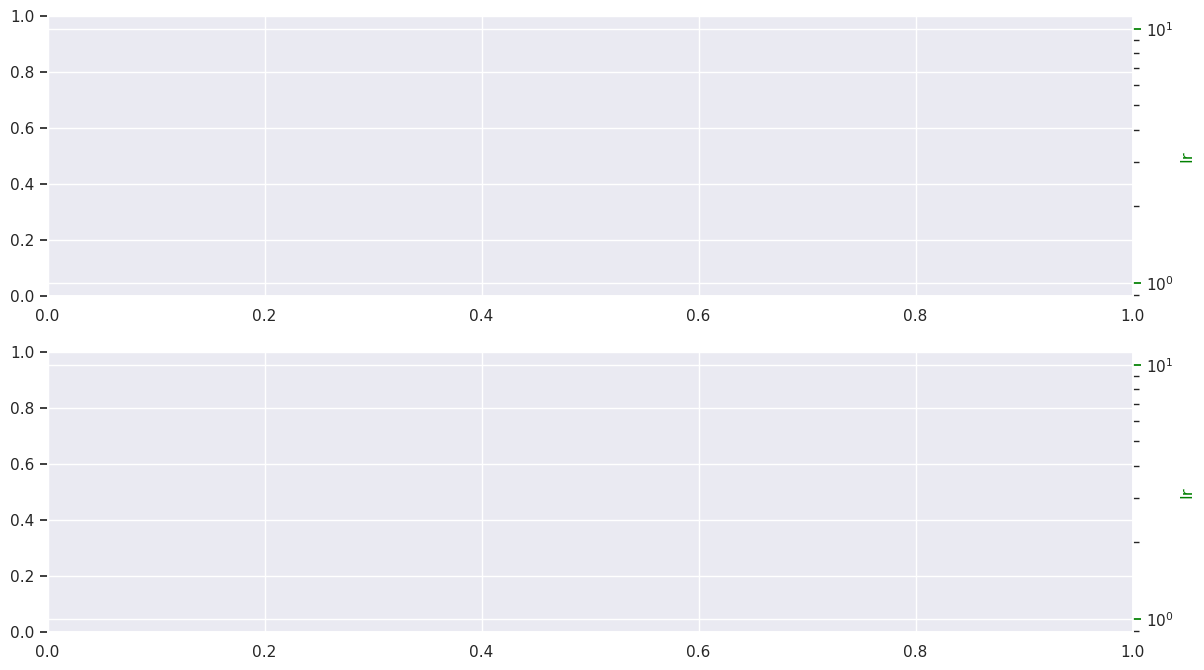

In [38]:
%matplotlib inline
cfg = Config(compounds_str)
cfg.setup(num_hidden=3, hidden_size=len(cfg.all_mol_names), lr=1e-4)

num_batches = 10
batch_size = 1000
data_train = gen_examples(cfg, num_batches, batch_size)
data_val = gen_examples(cfg, num_batches, batch_size)

train_losses = list()
val_losses = list()
val_diffs = list()
val_dists = list()
learning_rates = list()

plt.rcParams["figure.figsize"] = (14, 8) # (w, h)

# fig, ax_val_losses = plt.subplots()
fig = plt.gcf()
ax_val_losses = fig.add_subplot(2, 1, 1, label="val losses")
ax_val_dists = fig.add_subplot(2, 1, 2, label="val dists")

all_axes = [ax_val_losses, ax_val_dists]
all_axes_lr = [ax.twinx() for ax in all_axes]

color_lr = "green"
for ax in all_axes_lr:
    ax.set_yscale("log")
    ax.set_label("learning rate")
    ax.tick_params(axis='y', color=color_lr)
    ax.set_ylabel("lr", color=color_lr)

num_mol = len(cfg.all_mol_names)
for num_hidden in [5]:
    for hidden_size in [num_mol * 4]:
        cfg.setup(num_hidden=num_hidden, hidden_size=hidden_size, lr=1e-4)

        print()
        print(f"num_hidden {num_hidden}, hidden_size {hidden_size}")
        for lr in [5e-5, 3e-5, 1e-5, 5e-6, 3e-6, 1e-6]:
            print(f"lr = {lr} (num_hidden {num_hidden}, hidden_size {hidden_size})")
            epochs = 5000
            cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=lr)

            tlosses, vlosses, vdists = train(cfg, epochs, data_train, data_val)

            train_losses.extend(tlosses)
            val_losses.extend(vlosses)
            val_dists.extend(vdists)
            learning_rates.extend([lr] * epochs)

            all_vals = [val_losses, val_dists]

            for axes, axes_lr, vals in zip(all_axes, all_axes_lr, all_vals):
                axes.clear()
                axes.plot(vals, label=axes.get_label())
                lines, labels = axes.get_legend_handles_labels()

                axes_lr.clear()
                axes_lr.plot(learning_rates, color=color_lr, label=axes_lr.get_label())
                lines_lr, labels_lr = axes_lr.get_legend_handles_labels()

                axes.legend(lines_lr + lines, labels_lr + labels, loc=0)

            
            # fig.tight_layout()
            display.clear_output(True)
            display.display(fig)



In [ ]:
cfg.optim = torch.optim.AdamW(cfg.net.parameters(), lr=1e-6)
tlosses, vlosses = train(cfg, epochs, data_train, data_val)


epoch 240/5000: train loss 0.03431, val loss 0.03375
epoch 482/5000: train loss 0.03423, val loss 0.03365
epoch 723/5000: train loss 0.03425, val loss 0.03375
epoch 964/5000: train loss 0.03422, val loss 0.03373
epoch 1203/5000: train loss 0.03417, val loss 0.03368
epoch 1444/5000: train loss 0.03412, val loss 0.03364
epoch 1683/5000: train loss 0.03413, val loss 0.03358
epoch 1926/5000: train loss 0.03411, val loss 0.03361
epoch 2167/5000: train loss 0.03411, val loss 0.03365
epoch 2407/5000: train loss 0.03408, val loss 0.03352
epoch 2648/5000: train loss 0.03409, val loss 0.03356
epoch 2889/5000: train loss 0.03396, val loss 0.03350
epoch 3130/5000: train loss 0.03398, val loss 0.03341
epoch 3372/5000: train loss 0.03392, val loss 0.03337
epoch 3612/5000: train loss 0.03391, val loss 0.03340
epoch 3853/5000: train loss 0.03390, val loss 0.03339
epoch 4096/5000: train loss 0.03382, val loss 0.03327
epoch 4340/5000: train loss 0.03384, val loss 0.03333
epoch 4581/5000: train loss 0.03

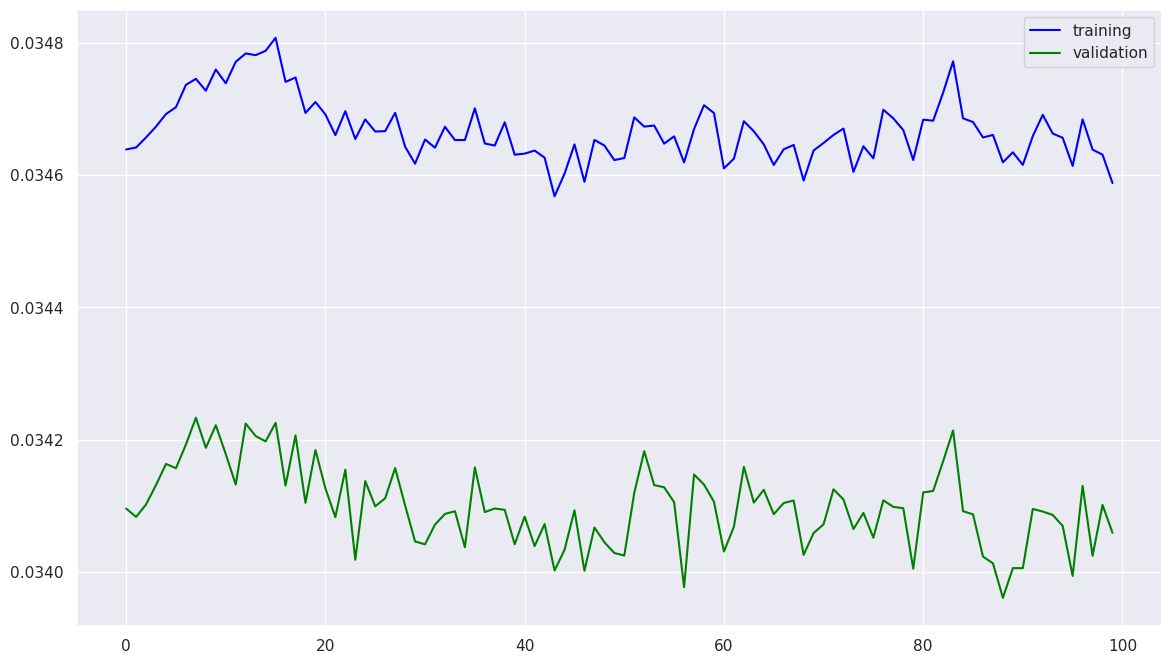

In [ ]:
smoothed = torch.Tensor(tlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="training", color="blue")
smoothed = torch.Tensor(vlosses).view(-1, 50).mean(dim=1)
plt.plot(smoothed, label="validation", color="green")
plt.legend()

